In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

,time,V_ai0
0,0 sec,2.574507
1,0.00025 sec,2.579598
2,0.0005 sec,2.574507
3,0.00075 sec,2.579598
4,0.001 sec,2.574507
...,...,...
79995,19.999 sec,2.943606
79996,19.999 sec,2.938515
79997,19.999 sec,2.943606
79998,19.999 sec,2.935970


Text(0.5, 1.0, 'Smoothed Voltage')

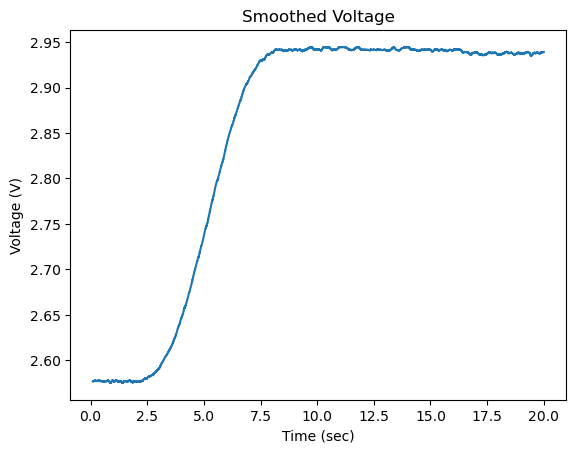

In [3]:
# process csv
date = '20-Nov-2024'
trial = 2
filename = f'{date}_sensor_data{trial}.csv'
df = pd.read_csv(filename)
display(df)

# delete ' sec' from t dataset
raw_t = np.array(df['time'].values)
t = np.zeros(len(raw_t))
for k in range(len(raw_t)):
    t[k] = raw_t[k][:-4]

# smooth data
window = 400
V_smooth = np.array(df['V_ai0'].rolling(window).mean().values)
V_smooth = V_smooth[window-1:]  # cut off nan values
t = t[window-1:]                # cut t to same size as V_smooth

# plot voltage over time
plt.plot(t, V_smooth)
plt.xlabel('Time (sec)')
plt.ylabel('Voltage (V)')
plt.title('Smoothed Voltage')

In [4]:
def V_to_htank(V):              # convert voltage to height
    return 2.3017*V + 4.3401

def approx_dVdt(t,V):           # calculate dV/dt
    dVdt = np.zeros(len(t))
    for k in range(0,len(t)-1):
        dVdt[k] = (V[k+1] - V[k])/(t[k+1] - t[k])
    return dVdt

def flow_rate(dVdt, A):         # calculate flow rate
    return 2.3017*dVdt*A

Text(0, 0.5, 'Water surface depth (cm)')

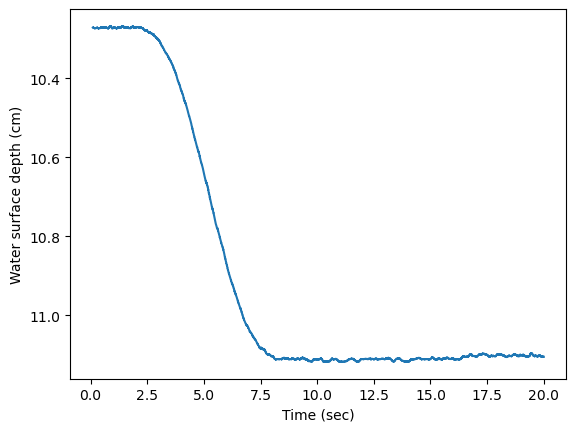

In [5]:
# plot water surface depth vs time

plt.plot(t, V_to_htank(V_smooth))
plt.gca().invert_yaxis()
plt.xlabel('Time (sec)')
plt.ylabel('Water surface depth (cm)')

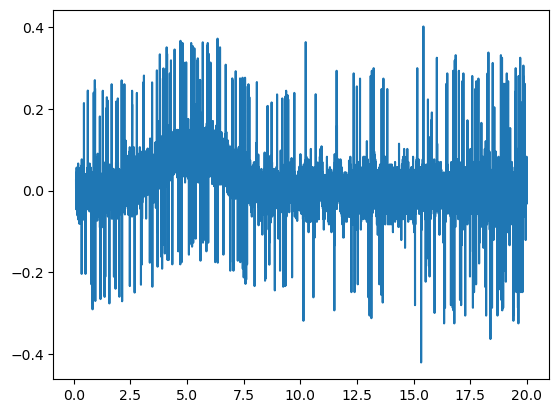

In [6]:
h = 5
t_sample = t[::h]
V_sample = V_smooth[::h]

dVdt = approx_dVdt(t_sample, V_sample)

plt.plot(t_sample, dVdt)

Text(0, 0.5, 'Flow rate (mL/s)')

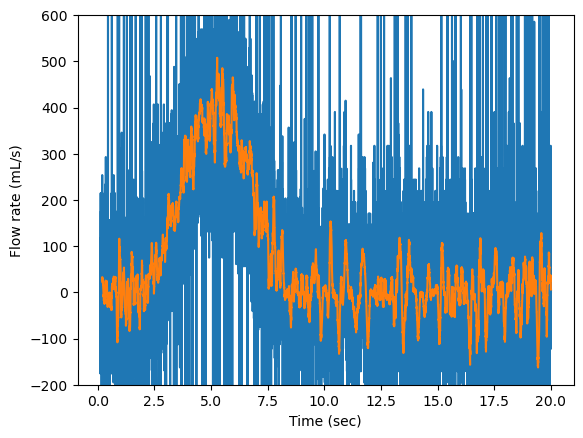

In [44]:
# calculate flow rate

tank_OC = 57.75 # inches
thickness = 0.125 # inches
tank_OD = 57.75/np.pi # inches
tank_ID = (tank_OD - 2*thickness)*2.54 # cm
tank_A = 0.25*np.pi*(tank_ID**2)

Q = 2.3017*dVdt*tank_A

window2 = 70
dfq = pd.DataFrame({'Time': t_sample, 'Flow': Q})
Q_smooth = np.array(dfq['Flow'].rolling(window2).mean().values)

t_smooth = t_sample[window2-1:]
Q_smooth = Q_smooth[window2-1:]

plt.plot(t_sample, Q)
plt.plot(t_smooth, Q_smooth)
plt.ylim(-200, 600)
plt.xlabel('Time (sec)')
plt.ylabel('Flow rate (mL/s)')

In [ ]:
# calculate flow volume

def trap(t, Q):
  '''
  t = array of time values
  Q = flow rate values
  '''
  total = 0
  for i in range(len(t) - 1):
      h = t[i+1] - t[i]
      inc = (h/2)*(Q[i+1] + Q[i])
      total = total + inc
  return total

def simpson(t, Q):
  total = 0
  for i in range(0, len(t) - 2, 2):
      h = t[i+1] - t[i]
      inc = (h/3)*(Q[i] + 4*Q[i+1] + Q[i+2])
      total = total + inc
  return total

vol_trap = trap(t_sample, Q)
vol_simpson = simpson(t_sample, Q)
print(f'Calculated volume from trapezoidal integration: {vol_trap}')
print(f'Calculated volume from Simpson\'s 1/3 rule: {vol_simpson}')

Calculated volume from trapezoidal integration: 1388.4526471554043
Calculated volume from Simpson's 1/3 rule: 1362.932801143834
